In this project, a change point model was implemented using PyMC3. The prior probabilities and the posterior probability distribution was based off the one provided in section two of "Bayesian Inference: Gibbs Sampling" by Ilker Yildirim at the University of Rochester. A table of the data and the statistics generated by the model is shown, as well as the true means of each data cluster which are printed to the terminal for comparison.

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [n]
>NUTS: [λ_2, λ_1]


Sampling 2 chains for 1_000 tune and 5_200 draw iterations (2_000 + 10_400 draws total) took 10 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
n,25.53,7.19,4.00,37.00,1.51,1.08,49.54,19.52,1.04
λ_1,0.91,0.31,0.47,1.33,0.03,0.02,344.44,114.38,1.01
λ_2,1.90,0.35,1.24,2.51,0.03,0.02,87.22,85.42,1.02


True Values: 
n = 25
λ_1 = 0.8 
λ_2 = 1.88


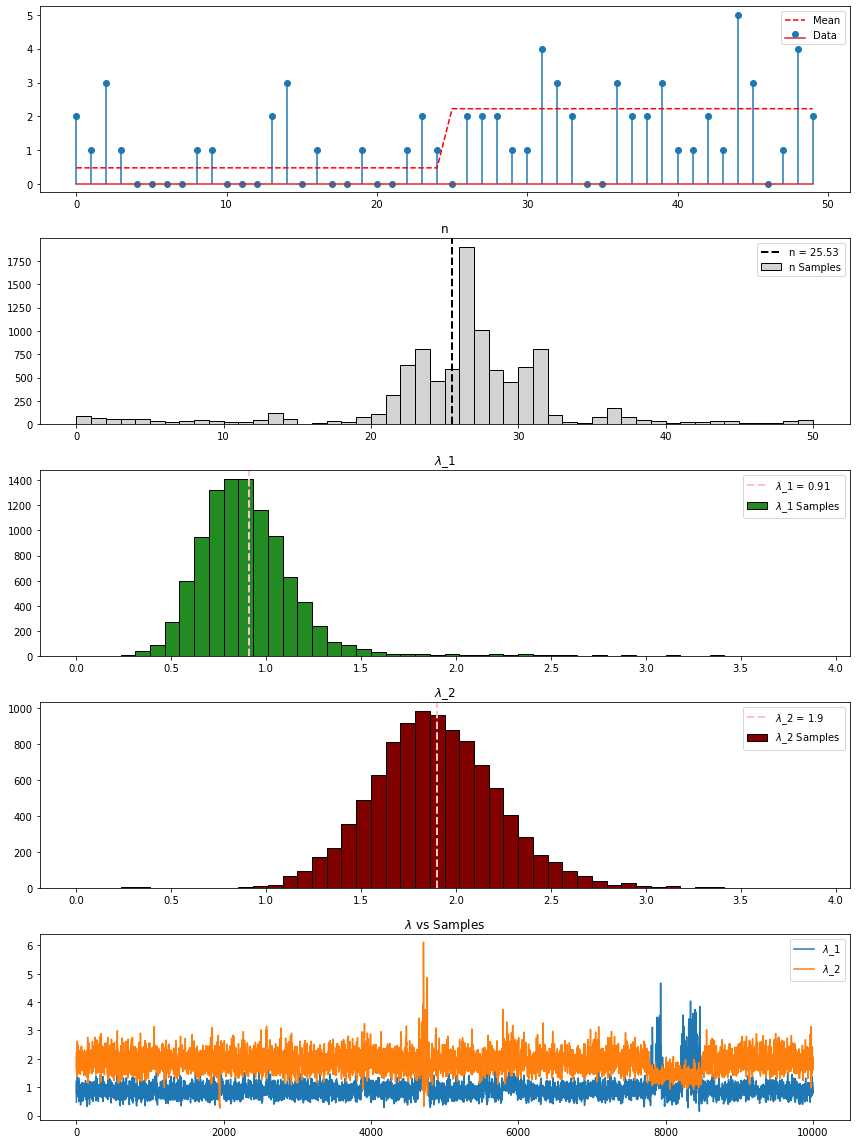

In [ ]:
#Project 7 | Sampling with PyMC3
#Layth Yassin, Husam Almanakly, and Ali Ghuman

import numpy as np
from scipy.stats import poisson, gamma
import matplotlib.pyplot as plt
import matplotlib as mpl
import pymc3 as pm
import arviz as az


#Set up subplot for histograms
figure, ax = plt.subplots(5, 1, figsize=[12,16])

#Initialize Variables
a = 2
b = 1
N = 50
n = 25

lamb1 = np.random.gamma(a,1/b)
lamb2 = np.random.gamma(a,1/b)*4
x1 = np.random.poisson(lamb1,n)
x2 = np.random.poisson(lamb2,(N-n))
x = np.concatenate((x1,x2))

lambdas = [lamb1] * n + [lamb2] * (N-n)

#Plot Data Points
ax[0].stem(range(N), x, use_line_collection=True, label='Data')
ax[0].plot(range(N),lambdas,'r--', label='Mean')
ax[0].legend()
#plt.scatter(x2, xaxis)

#Use PyMC3 API to sample the Change Point Model
mod = pm.Model()
with mod:
    #Initialize all the priors using Equation set 4 From the Gibbs Sampling paper
    n_prime = pm.DiscreteUniform('n',0, N)
    lambda1 = pm.Gamma('λ_1',a,b)
    lambda2 = pm.Gamma('λ_2',a,b)

    #Assign lambdas depending on n value
    index = np.arange(0,N)
    lambda_prime = pm.math.switch(n_prime > index, lambda1, lambda2)

    #Distribution were sampling from (all our data passed into observed)
    x = pm.Poisson('x1',lambda_prime, observed=x)

with mod:
    # draw 5200 posterior samples, leave 200 for burn in like paper
    trace = pm.sample(5200, return_inferencedata=False)

#Plot Results
with mod:
    display(az.summary(trace, round_to=2))

#extract samples and burn first 200 samples 
ns = trace['n', 200:]
lam1 = trace['λ_1', 200:]
lam2 = trace['λ_2', 200:]

tmp = max(np.mean(x2),np.mean(x1))
c = np.round(sum(trace['λ_1'])/len(trace['λ_1']),2)
c2 = np.round(sum(trace['λ_2'])/len(trace['λ_2']),2)
c3 = np.round(sum(trace['n'])/len(trace['n']),2)

#Plot each histogram and dashed line of means
#n 
ax[1].set_title('n')
ax[1].hist(ns, bins=50, edgecolor='black', color='lightgrey', label = f'n Samples')
ax[1].axvline(c3, color='black', linestyle='dashed', linewidth=2, label = f'n = {c3}')
ax[1].legend()

#Lambda1
ax[2].set_title('$\lambda$_1')
ax[2].hist(lam1, bins=50,edgecolor='black', color = 'forestgreen',range=(0,2+tmp), label = f'$\lambda$_1 Samples')
ax[2].axvline(c, color='pink', linestyle='dashed', linewidth=2, label = f'$\lambda$_1 = {c}')
ax[2].legend()

#Lambda2
ax[3].set_title('$\lambda$_2')
ax[3].hist(lam2, bins=50, edgecolor='black', color='maroon', range=(0,2+tmp), label = f'$\lambda$_2 Samples')
ax[3].axvline(c2, color='pink', linestyle='dashed', linewidth=2, label = f'$\lambda$_2 = {c2}')
ax[3].legend()

#Lambda plotted against samples
xaxis = np.linspace(0,len(lam1),len(lam1))
ax[4].set_title('$\lambda$ vs Samples')
ax[4].plot(xaxis,lam1, label = '$\lambda$_1')
ax[4].plot(xaxis,lam2, label = '$\lambda$_2')
ax[4].legend()
plt.tight_layout()

print(f'True Values: \nn = {n}')
print(f'λ_1 = {np.mean(x1)} \nλ_2 = {np.mean(x2)}')